# Zero-shot Classification with PLIP

In this example notebook we will:

- Generate 1 µm/px image embeddings of images from the [Camelyon17 dataset](https://camelyon17.grand-challenge.org/) dataset
- Build a zero-shot tile-level classification system using PLIP's text encoder
- Generate heatmaps from model predictions
- Insert results back into Concentriq LS® for visualization

In [1]:
import cv2
import imageio
import numpy as np
import os
import pandas as pd
import scipy as sp
import torch
import yaml

from proscia_ai_tools.client import ClientWrapper as Client

In [2]:
with open('creds.yml', 'r') as file:
    creds = yaml.safe_load(file)

# To use CPU instead of GPU for working with the embeddings, set `device` parameter to `"cpu"`,
# otherwise set it to the GPU id (e.g. `"cuda:0"`)
ce_api_client = Client(**creds, device='cpu')
ce_api_client

# Let's get some embeddings

Now let's embed an image from the Camelyon17 repo (stored on Concentriq® LS with repo ID 2784) at 1 mpp resolution using `vinid/plip`, and print out the ticket ID. 

In [3]:
repository_ids = [2]
image_ids = [76]
ticket_id = ce_api_client.embed_images(ids=image_ids, model="vinid/plip", mpp=1)

# Optionally load embeddings from a previously created ticket
#ticket_id = "6959742e-0e36-4493-91bb-74df61e6a27f"

In [6]:
embeddings = ce_api_client.get_embeddings(ticket_id, polling_interval_seconds=30)

In [7]:
len(embeddings['images'])

1

In [8]:
embedding_dim = embeddings['images'][0]['embedding']['0_0'].shape[0]
embedding_dim

512

Congratulations, you're now a foundation model wizard. You have your embeddings in just a few lines of code!

# Let's match embeddings to metadata
We're going to want to associate embeddings with the corresponding image names. Concentriq® Embeddings already links images to an ID, so we just want to match those Concentriq® `image_id`s with `image_names`. Other metadata can be linked this way too. Here we're just pulling this data using the `ConcentriqLSClient` using the `get_images_in_a_repo` method. The `ConcentriqLSClient` uses the same authentication credentials as the embeddings API.

In [9]:
from proscia_ai_tools.concentriqlsclient import ConcentriqLSClient

cls = ConcentriqLSClient(**creds)
concentriq_metadata = cls.get_images_in_a_repo(repository_ids[0])

columns = ["id", "mppx", "mppy", "imgWidth", "imgHeight", "objectivePower", "slideName"]
concentriq_metadata = pd.DataFrame(concentriq_metadata["images"])[columns]
concentriq_metadata.rename(columns={"id": "image_id"}, inplace=True)

concentriq_metadata["image_base_name"] = concentriq_metadata["slideName"].apply(lambda x: x.split(".")[0])
print(concentriq_metadata.shape)
concentriq_metadata.head()

(50, 8)


,image_id,mppx,mppy,imgWidth,imgHeight,objectivePower,slideName,image_base_name
0,60,0.243094,0.243094,94968,210579,40,patient_009_node_1.tif,patient_009_node_1
1,61,0.243094,0.243094,96651,197226,40,patient_010_node_4.tif,patient_010_node_4
2,62,0.243094,0.243094,96651,197226,40,patient_012_node_0.tif,patient_012_node_0
3,63,0.243094,0.243094,94968,210579,40,patient_020_node_4.tif,patient_020_node_4
4,64,0.243094,0.243094,94968,210579,40,patient_021_node_3.tif,patient_021_node_3


The retrieved embedding file includes metadata about the embeddings job we submitted and each WSI processed. The embeddings themselves are loaded as a dictionary of tensors with keys in "Y_X" format indicating the grid index of the embedded patch.

Here we print the information corresponding to each WSI. This includes the parameters supplied along with implicit attributes of the data, like the foundation model’s native patch size, as well as all of the other spatial information associated with each WSI’s tile embeddings.

In [10]:
for key, value in embeddings['images'][0].items():
    if key not in ['embedding', 'embeddings_url']:
        print(f"{key}: {value}")

image_id: 76
repository_id: None
status: finished
model: vinid/plip
patch_size: 224
grid_rows: 229
grid_cols: 104
pad_height: 106
pad_width: 210
mpp: 1.0
local_embedding_path: ./data/443fb8d8-759d-4822-bdbc-213943ec969c_76.safetensors


# ... And add tile-level labels
Now we want to match each tile embedding with its corresponding label. To do this, we can create a dataframe with one row per embedded tile along with the grid location and the mask value for that tile.


In [14]:
datapath = "data/camelyon17/masks/"
reslist = []
for i, row in concentriq_metadata.iterrows():
    image_id = row["image_id"]
    image_base_name = row["image_base_name"]
    emb = [e for e in embeddings['images'] if e["image_id"] == image_id]
    if len(emb) == 0:
        continue
    emb = emb[0]
    tile_res_mask_path = os.path.join(datapath, f"{image_base_name}_mask.png")
    tile_res_mask = imageio.v2.imread(tile_res_mask_path)
    # For each image, create one row per tile in the mask
    for i in range(emb["grid_rows"]):
        for j in range(emb["grid_cols"]):
            mask_value = tile_res_mask[i, j]
            res = {"image_id": image_id,
                   "image_base_name": image_base_name,
                   "label": mask_value,
                   "row": i,
                   "col": j,
                   "embedding": emb["embedding"][f"{i}_{j}"],
                   "grid_rows": emb["grid_rows"],
                   "grid_cols": emb["grid_cols"]}
            reslist.append(res)
dataset_df = pd.DataFrame(reslist)
del embeddings # Free up memory
del reslist # Free up memory
dataset_df.shape

(23816, 8)

In [15]:
dataset_df.head()

,image_id,image_base_name,label,row,col,embedding,grid_rows,grid_cols
0,76,patient_017_node_2,0,0,0,"[tensor(0.1216), tensor(-0.1216), tensor(-0.49...",229,104
1,76,patient_017_node_2,0,0,1,"[tensor(0.1216), tensor(-0.1216), tensor(-0.49...",229,104
2,76,patient_017_node_2,0,0,2,"[tensor(0.1216), tensor(-0.1216), tensor(-0.49...",229,104
3,76,patient_017_node_2,0,0,3,"[tensor(0.1216), tensor(-0.1216), tensor(-0.49...",229,104
4,76,patient_017_node_2,0,0,4,"[tensor(0.1216), tensor(-0.1216), tensor(-0.49...",229,104


In [16]:
dataset_df['label'].value_counts()

label
0    20600
1     2985
2      231
Name: count, dtype: int64

Restrict the dataset to tiles containing tissue.

In [17]:
dataset_df = dataset_df[dataset_df['label'] > 0]
dataset_df.index = range(len(dataset_df))
dataset_df.shape

(3216, 8)

# Zero Shot Learning

We'll import the text encoder and encode a set of labels. 

In [18]:
from transformers import AutoProcessor, CLIPModel

processor = AutoProcessor.from_pretrained("vinid/plip")
model = CLIPModel.from_pretrained("vinid/plip")

labels = {
    1: {"text": "lymph node"},
    2: {"text": "metastatic cancer"}, # Our positive class
    3: {"text": "adipose"},
    4: {"text": "healthy"},
    5: {"text": "tissue"},
    6: {"text": "benign"},
    7: {"text": "negative"},
    8: {"text": "background"},
}

for k, v in labels.items():
    input = processor(v["text"], return_tensors="pt", padding=False)
    v["text_embedding"] = model.get_text_features(**input).detach()[0].numpy()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


And next compute the similarity between our text encodings and tile-level image encodings.

In [19]:
def similarity(a: np.ndarray, b: np.ndarray) -> float:
    """dot-product similarity between two vectors"""
    return np.dot(a, b)


def get_similarity_df(tiles_df, labels):
    reslist = []
    for _, row in tiles_df.iterrows():
        tile_emb = row.pop("embedding")
        tile_emb = tile_emb.type(torch.float32).numpy()
        res = row.to_dict()
        for k, v in labels.items():
            sim = similarity(tile_emb, v["text_embedding"])
            res.update({f'{k}_similarity': sim})
        reslist.append(res)
    similarity_df = pd.DataFrame(reslist)
    
    cols = [f"{k}_similarity" for k in labels]
    softmax = sp.special.softmax(similarity_df[cols].values, axis=1)
    score_cols = [f"{k}_score" for k in labels]
    similarity_df[score_cols] = softmax

    return similarity_df

## Create a 2d array containing the tile-level predictions for a given slide

In [20]:
image_id = image_ids[0] # An id of a test image
slide_df = dataset_df[dataset_df['image_id']==image_id].copy()
slide_df = get_similarity_df(slide_df, labels)
mat = np.zeros((slide_df['grid_rows'].values[0], slide_df['grid_cols'].values[0]))

for i, row in slide_df.iterrows():
    score = row['2_score']
    mat[row['row'], row['col']] = score
    
# We'll also get the ground truth mask for this image to compare
image_base_name = slide_df['image_base_name'].values[0]
tile_resolution_mask = imageio.v2.imread(os.path.join(datapath, f"{image_base_name}_mask.png"))

# Scale the tile-level mask from 225 mpp (tile-resolution [patch-size x embedding mpp]) to a 1 mpp binary mask
tile_resolution_mask = cv2.resize(tile_resolution_mask, (tile_resolution_mask.shape[1]*225, tile_resolution_mask.shape[0]*225), 0, 0, interpolation=cv2.INTER_NEAREST)
tile_resolution_mask = tile_resolution_mask == 2


# Upload a heatmap overlay image to Concentriq LS®

Using the `insert_heatmap_overlay` method provided by the `ConcentriqLSClient`, we can insert our results back into the platform with a single line of code.

In [21]:
cls.insert_heatmap_overlay(image_id=image_id, heatmap=mat, result_name="Zero-Shot PLIP")

### Insert ground truth annotation for comparison

Similarly, we can insert the ground truth tumor regions into the platform for viewing. Using the `insert_annotations_from_mask` method, this can also be done with a single line of code.

In [22]:
annotations = cls.insert_annotations_from_mask(
    image_id=image_id, 
    mask=tile_resolution_mask,
    mask_mpp=1, 
    annotation_name="Tumor Ground Truth"
)

# Result

The overlay can now be viewed in Concentriq® LS.

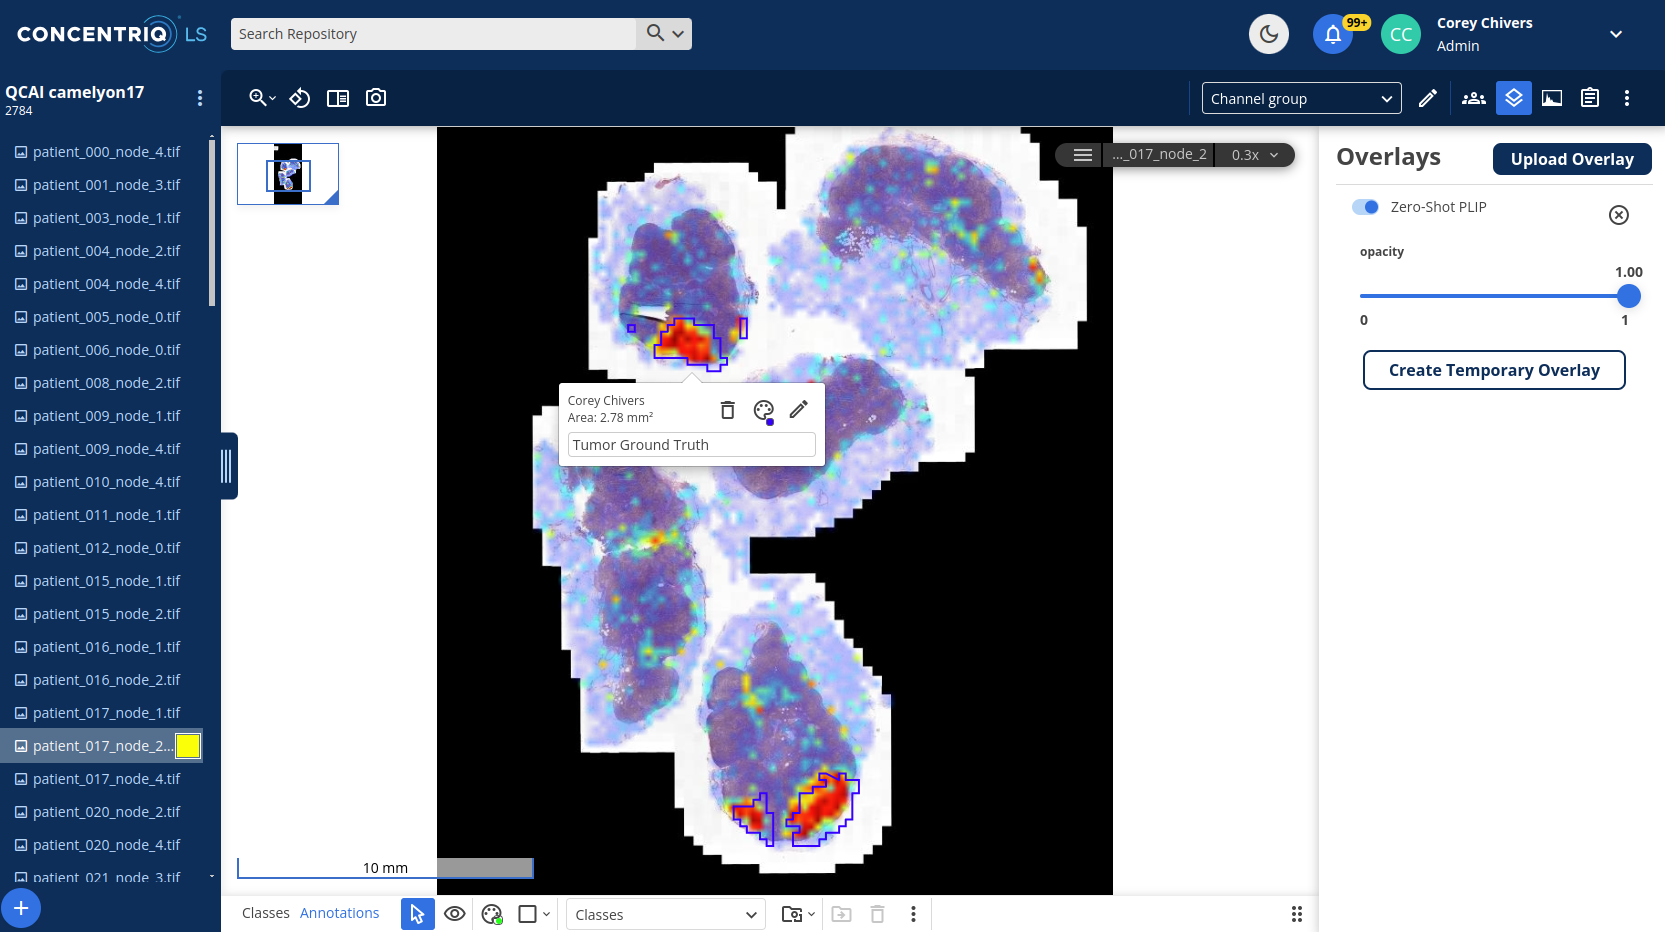